# Mount Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Ignore Warning

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Install packages

In [ ]:
!pip install mne

# Create a Specific Folder in Google Drive

In [1]:
import os

# Define the folder path
folder_path = '/content/drive/MyDrive/MyOutput'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


# Model Training

## Load and Inspect the numpy File

In [21]:
import pandas as pd
import numpy as np


# Load the .npz file
data = np.load('/content/CombinedFile_6Subjects_50_testing_CSP_Features.npz')

# List all arrays in the .npz file
print(data.files)

# Access and print each array

for array_name in data.files:
    print(array_name)
    print(data[array_name])






['features', 'labels']
features
[[-1.90870635 -0.29377429 -0.40836448 ... -0.86416276 -0.67967745
  -0.87754483]
 [ 0.19074051 -0.48813012  0.07289046 ...  0.14512032 -0.30840483
  -0.93400415]
 [-1.54598618 -0.758312   -0.63416532 ... -0.41448695 -0.45770711
  -0.81797092]
 ...
 [-1.24999741 -1.43994603 -0.81837836 ... -1.48299788 -1.37180942
  -1.13992731]
 [-1.25960391 -1.37920593 -1.45633972 ... -1.50528596 -1.46905574
  -1.02324979]
 [-1.31036863 -0.94014314 -0.756988   ... -1.08614067 -0.74169381
  -1.04778939]]
labels
[[351788      1      1      1]
 [358546      1      1      1]
 [365390      3      1      1]
 ...
 [945512      2      1      3]
 [952253      2      1      3]
 [959079      1      1      3]]


In [22]:
data['labels'].shape

(1316, 4)

In [23]:
labels= data['labels']
labels= labels[:, 1]
labels.shape


(1316,)

In [24]:


unique, frequency = np.unique(labels,
                              return_counts = True)

# convert both into one numpy array
count = np.asarray((unique, frequency ))

print("The values and their frequency are:\n",
     count)

The values and their frequency are:
 [[  0   1   2   3]
 [329 329 329 329]]



**Data Cleaning and preparation for numpy files**

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import joblib


# Assuming 'Feature' and 'Label' are keys in the npz file
features = data['features']

# Function to clean feature strings
def clean_feature_string(feature_str):
    if isinstance(feature_str, str):
        cleaned = feature_str.strip('[]').replace(' ', ',').replace('\n', '')
        return cleaned.split(',') if cleaned else []
    return feature_str  # If it's already a list or array, return as is

# Convert the feature strings to lists of floats
cleaned_features = []
for feature in features:
    cleaned_feature = clean_feature_string(feature)
    if len(cleaned_feature) == 0:
        cleaned_feature = [0.0] * 10  # Handle empty features by filling with placeholder
    cleaned_features.append([float(i) for i in cleaned_feature])

# Convert cleaned_features to a numpy array
X = np.array(cleaned_features)
y=labels
# Optional: Split the data into training and testing sets

'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical (if using TensorFlow/Keras)
num_classes = len(np.unique(y))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print("First few rows of scaled features:")
print(X_train[:5])
print("First few labels (one-hot encoded):")
print(y_train[:5])

print("Data cleaning and preparation complete.")
'''


'\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Convert labels to categorical (if using TensorFlow/Keras)\nnum_classes = len(np.unique(y))\ny_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)\ny_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)\n\nprint("First few rows of scaled features:")\nprint(X_train[:5])\nprint("First few labels (one-hot encoded):")\nprint(y_train[:5])\n\nprint("Data cleaning and preparation complete.")\n'

In [26]:

X.shape

(1316, 50)

In [27]:


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [28]:
from sklearn.preprocessing import RobustScaler
scaler=RobustScaler()
features_resampled_scaled = scaler.fit_transform(X_train)
features_test_scaled = scaler.transform(X_test)  # Use the same scaler to transform test data




In [29]:
features_resampled_scaled.shape

(1052, 50)

In [30]:

num_classes = len(np.unique(y_train))
labels_resampled = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
labels_resampled

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [31]:
num_classes = len(np.unique(y_test))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
y_test

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

**CNN** **MODEL**

In [32]:

import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
import random



np.random.seed(2017)


# Reshape the features for CNN input
X_train_reshaped = features_resampled_scaled.reshape(features_resampled_scaled.shape[0], features_resampled_scaled.shape[1], 1)
X_test_reshaped = features_test_scaled.reshape(features_test_scaled.shape[0], features_test_scaled.shape[1], 1)



model =  Sequential([
    Conv1D(128, 3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1),kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.7),


    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.7),
    Dense(num_classes, activation='softmax')  # Adjust the output layer based on the number of classes
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot encoded labels back to original class labels
y_train_classes = np.argmax(labels_resampled, axis=1)

# Compute class weights

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights_dict = dict(enumerate(class_weights))

# Adjust class weights moderately
for key in class_weights_dict:
    class_weights_dict[key] = class_weights_dict[key] * 1.25  # Increase weights moderately


# Evaluate the model

# Model summary
model.summary()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_reshaped, labels_resampled, validation_data=(X_test_reshaped, y_test),
                    epochs=200, batch_size=32, callbacks=[early_stopping],shuffle=False, verbose=2)#class_weight=class_weights_dict)

# Define the file path where the model will be saved
model_file_path = os.path.join(folder_path, 'tested_3_cnn_model')



# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f'CNN Model Accuracy: {accuracy:.2%}')

# Make predictions and evaluate
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Generate a classification report
from sklearn.metrics import classification_report
report = classification_report(y_test_classes, y_pred_classes)
print('CNN Model Classification Report:')
print(report)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 48, 128)           512       
                                                                 
 batch_normalization_2 (Bat  (None, 48, 128)           512       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 24, 128)           0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 128)           0         
                                                                 
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_18 (Dense)            (None, 128)              

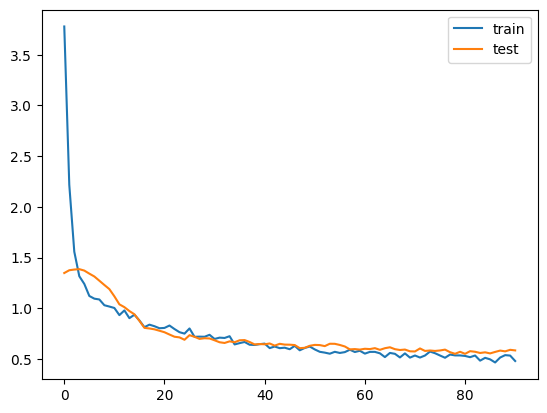

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()


# Updated model

## Save the model

In [33]:
# Save the model
model.save(model_file_path)


## K-fold |Model 1

In [118]:
import numpy as np
import os
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Ensure your data is already loaded and prepared

# K-Fold Cross Validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define arrays to store results
fold_no = 1
losses = []
accuracies = []

X = features_resampled_scaled
y = labels_resampled

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Reshape for CNN input
    X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1)
    X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], X_val_fold.shape[1], 1)

    # Convert one-hot encoded labels back to original class labels for class weight calculation
    y_train_classes = np.argmax(y_train_fold, axis=1)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
    class_weights_dict = dict(enumerate(class_weights))

    # Adjust class weights moderately
    for key in class_weights_dict:
        class_weights_dict[key] = class_weights_dict[key] * 1.25

    # Define the CNN model
    model = Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(X_train_fold.shape[1], 1), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.7),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.7),
        Dense(y_train_fold.shape[1], activation='softmax')  # Adjust the output layer based on the number of classes
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
                        epochs=100, batch_size=32, callbacks=[early_stopping], verbose=2, class_weight=class_weights_dict)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Fold {fold_no} - Loss: {loss:.4f}, Accuracy: {accuracy:.2%}')

    losses.append(loss)
    accuracies.append(accuracy)

    fold_no += 1

# Print average scores
print(f'Average Loss across all folds: {np.mean(losses):.4f}')
print(f'Average Accuracy across all folds: {np.mean(accuracies):.2%}')


Epoch 1/100
27/27 - 2s - loss: 5.1692 - accuracy: 0.2723 - val_loss: 1.3780 - val_accuracy: 0.4550 - 2s/epoch - 87ms/step
Epoch 2/100
27/27 - 0s - loss: 2.7787 - accuracy: 0.4067 - val_loss: 1.3855 - val_accuracy: 0.4502 - 182ms/epoch - 7ms/step
Epoch 3/100
27/27 - 0s - loss: 2.0041 - accuracy: 0.4185 - val_loss: 1.3900 - val_accuracy: 0.4171 - 216ms/epoch - 8ms/step
Epoch 4/100
27/27 - 0s - loss: 1.7847 - accuracy: 0.4685 - val_loss: 1.3900 - val_accuracy: 0.4171 - 195ms/epoch - 7ms/step
Epoch 5/100
27/27 - 0s - loss: 1.5345 - accuracy: 0.4863 - val_loss: 1.3831 - val_accuracy: 0.4360 - 134ms/epoch - 5ms/step
Epoch 6/100
27/27 - 0s - loss: 1.4260 - accuracy: 0.5125 - val_loss: 1.3692 - val_accuracy: 0.4597 - 141ms/epoch - 5ms/step
Epoch 7/100
27/27 - 0s - loss: 1.3823 - accuracy: 0.5279 - val_loss: 1.3454 - val_accuracy: 0.4929 - 146ms/epoch - 5ms/step
Epoch 8/100
27/27 - 0s - loss: 1.3163 - accuracy: 0.5541 - val_loss: 1.3216 - val_accuracy: 0.5166 - 137ms/epoch - 5ms/step
Epoch 9/10

## Save K fold model

In [ ]:
# Inside your loop after training the model
model_path = f'/content/drive/MyDrive/ModelOutputs/cnn_model_fold_{fold_no}.h5'
model.save(model_path)
print(f'Saved model for fold {fold_no} at {model_path}')


Saved model for fold 6 at /content/drive/MyDrive/ModelOutputs/cnn_model_fold_6.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing

**Read test numpy file**

In [18]:
!unzip /content/blocks-testing.zip -d /content/

Archive:  /content/blocks-testing.zip
  inflating: /content/blocks/subject_2_block_2_testing_50_CSP_Features.npz  
  inflating: /content/blocks/subject_8_block_1_testing_50_CSP_Features.npz  
  inflating: /content/blocks/subject_9_block_1_testing_50_CSP_Features.npz  
  inflating: /content/blocks/subject_7_block_2_testing_50_CSP_Features.npz  
  inflating: /content/blocks/subject_8_block_3_testing_50_CSP_Features.npz  
  inflating: /content/blocks/subject_7_block_1_testing_50_CSP_Features.npz  
  inflating: /content/blocks/subject_2_block_1_testing_50_CSP_Features.npz  
  inflating: /content/blocks/subject_2_block_3_testing_50_CSP_Features.npz  
  inflating: /content/blocks/subject_7_block_3_testing_50_CSP_Features.npz  
  inflating: /content/blocks/subject_9_block_3_testing_50_CSP_Features.npz  
  inflating: /content/blocks/subject_8_block_2_testing_50_CSP_Features.npz  
  inflating: /content/blocks/subject_9_block_2_testing_50_CSP_Features.npz  


In [33]:
import pandas as pd
import numpy as np


# Load the .npz file
new_data = np.load('/content/blocks/subject_9_block_2_testing_50_CSP_Features.npz')
# List all arrays in the .npz file
print(new_data.files)

# Access and print each array

for array_name in new_data.files:
    print(array_name)
    print(new_data[array_name])

new_data['features'].shape




['features', 'labels']
features
[[ 0.48875392 -0.89840649 -0.48407872 ... -0.16432919 -0.17102698
   0.11350036]
 [ 1.13073145 -1.44320754 -0.21878282 ... -0.23054738 -0.40618273
  -0.37264044]
 [ 0.26438056 -0.41610298 -0.79332694 ... -0.31707106 -0.22925015
  -0.56608851]
 ...
 [-0.31972822 -0.48843425 -0.40839506 ...  0.02057862 -0.52276422
  -0.585623  ]
 [-1.05596389 -1.27911481 -1.25993033 ...  0.34087616 -0.60916793
  -0.91123695]
 [-1.00416009 -1.18843323  2.34372977 ...  0.34415601 -0.69779873
  -0.61550921]]
labels
[[356714      1      1      1]
 [363523      1      1      1]
 [369991      0      1      1]
 ...
 [934739      1      1      2]
 [948238      1      1      2]
 [954877      2      1      2]]


(840, 50)

In [34]:
import seaborn as sns

<ipython-input-35-3a0bd1c95662>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_data['features'])


<Axes: ylabel='Density'>

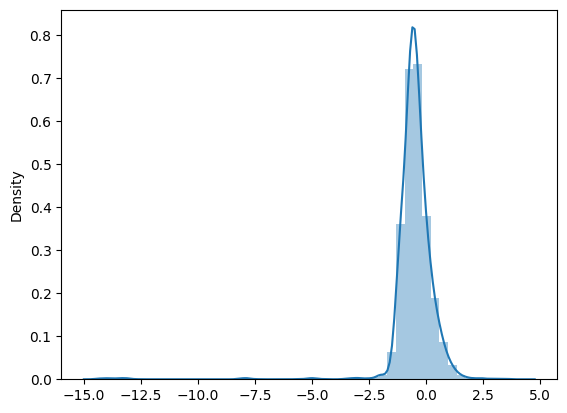

In [35]:
sns.distplot(new_data['features'])


**Preprocess and clean numpy file**

In [36]:



labels= new_data['labels']
labels= labels[:, 1]
labels.shape


(840,)

In [37]:


unique, frequency = np.unique(labels,
                              return_counts = True)

# convert both into one numpy array
count = np.asarray((unique, frequency ))

print("The values and their frequency are:\n",
     count)


The values and their frequency are:
 [[  0   1   2   3]
 [210 210 210 210]]


In [38]:





import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import joblib



# Load the .npz file

# Assuming 'Feature' and 'Label' are keys in the npz file
features = new_data['features']

# Function to clean feature strings
def clean_feature_string(feature_str):
    if isinstance(feature_str, str):
        cleaned = feature_str.strip('[]').replace(' ', ',').replace('\n', '')
        return cleaned.split(',') if cleaned else []
    return feature_str  # If it's already a list or array, return as is

# Convert the feature strings to lists of floats
cleaned_features = []
for feature in features:
    cleaned_feature = clean_feature_string(feature)
    if len(cleaned_feature) == 0:
        cleaned_feature = [0.0] * 10  # Handle empty features by filling with placeholder
    cleaned_features.append([float(i) for i in cleaned_feature])

# Convert cleaned_features to a numpy array
X_new = np.array(cleaned_features)
y_new= labels



In [39]:
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson


transformed_data = {}


    # Apply Yeo-Johnson transformation
transformed_array, lambda_value = yeojohnson(X_new.flatten())

    # Reshape transformed array to original shape
transformed_array = transformed_array.reshape(X_new.shape)

    # Standardize the transformed data
mean = np.mean(transformed_array)
std = np.std(transformed_array)
standardized_array = (transformed_array - mean) / std

    # Store the standardized data
transformed_data_new = standardized_array

    # Plot histogram of standardized data
plt.figure(figsize=(8, 6))
plt.hist(standardized_array.flatten(), bins=50, alpha=0.6, density=True)
plt.title(f'Histogram of Standardized Yeo-Johnson Transformed Data for X')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Optionally, save the transformed data back to a new npz file
'''
scaled_X_new= scaler.transform(X_new)


<ipython-input-40-f8d1aec07339>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scaled_X_new)


<Axes: ylabel='Density'>

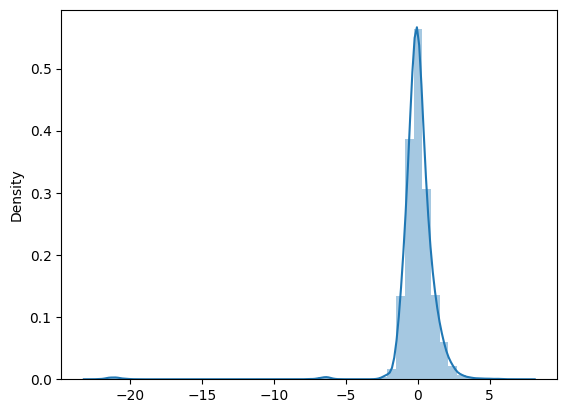

In [40]:
import seaborn as sns


sns.distplot(scaled_X_new)


In [41]:

y_new.shape

(840,)

In [42]:

# Reshape the data for the model if necessary (e.g., CNN input)
X_new_transformed = scaled_X_new.reshape(scaled_X_new.shape[0], scaled_X_new.shape[1], 1)

In [43]:

X_new_transformed.shape


(840, 50, 1)

In [44]:


model_path ='/content/drive/MyDrive/MyOutput/tested_3_cnn_model'
from keras import models
model = models.load_model(model_path)
print(f"Model loaded from {model_path}")


Model loaded from /content/drive/MyDrive/MyOutput/tested_3_cnn_model


In [45]:

# Assuming model and data are already loaded and prepared
from sklearn.metrics import accuracy_score
predictions = model.predict(X_new_transformed)
predicted_classes = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_new, predicted_classes)
print("Overall accuracy on test data: {:.2%}".format(accuracy))

from sklearn.metrics import classification_report
report = classification_report(y_new, predicted_classes)
print('CNN Model Classification Report:')
print(report)



27/27 [==============================] - 0s 2ms/step
Overall accuracy on test data: 27.86%
CNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.20      0.22       210
           1       0.23      0.33      0.28       210
           2       0.26      0.21      0.23       210
           3       0.37      0.38      0.38       210

    accuracy                           0.28       840
   macro avg       0.28      0.28      0.28       840
weighted avg       0.28      0.28      0.28       840



## Normalize the shape

In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on the extracted features
try:
    loss, accuracy = model.evaluate(csp_features_reshaped, labels_categorical, verbose=0)
    print(f'CNN Model Accuracy--> Testing: {accuracy:.2%}')
except ValueError as e:
    print(f"Error during model evaluation: {e}")

# Make predictions
try:
    y_pred = model.predict(csp_features_reshaped)
    y_pred_classes = np.argmax(y_pred, axis=1)
    labels_classes = np.argmax(labels_categorical, axis=1)

    # Generate a classification report
    report = classification_report(labels_classes, y_pred_classes)
    print('CNN Model Classification Report on Extracted Features:')
    print(report)
except ValueError as e:
    print(f"Error during model prediction: {e}")


CNN Model Accuracy--> Testing: 23.00%
7/7 [==============================] - 0s 4ms/step
CNN Model Classification Report on Extracted Features:
              precision    recall  f1-score   support

           0       0.38      0.32      0.35        50
           1       0.27      0.30      0.29        50
           2       0.18      0.20      0.19        50
           3       0.11      0.10      0.10        50

    accuracy                           0.23       200
   macro avg       0.23      0.23      0.23       200
weighted avg       0.23      0.23      0.23       200



In [ ]:
import mne
import numpy as np
from sklearn.preprocessing import StandardScaler

def extract_features_from_file(file_path):
    # Load the EEG data from the FIF file
    epochs = mne.read_epochs(file_path, preload=True)
    X = epochs.get_data()  # Get the data in (n_epochs, n_channels, n_times) format
    y = epochs.events[:, -1]  # Get the event labels

    # Reshape the data to be suitable for Conv1D
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Adjust labels to be zero-based
    label_mapping = {label: index for index, label in enumerate(np.unique(y))}
    y = np.array([label_mapping[label] for label in y])

    # Reshape the features for Conv1D input
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

    # Convert labels to categorical
    num_classes = len(np.unique(y))
    y_categorical = tf.keras.utils.to_categorical(y, num_classes=num_classes)

    return X_reshaped, y_categorical, num_classes

# Load the EEG data
file_path = '/content/drive/MyDrive/FYPD_Dataset/derivatives/sub-02/ses-02/sub-02_ses-02_eeg-epo.fif'  # Path to the uploaded EEG file
X_new, y_new, num_classes = extract_features_from_file(file_path)

print(f"Shape of new data (X_new): {X_new.shape}")
print(f"Shape of new labels (y_new): {y_new.shape}")

# Print model input shape
print(f"Expected input shape by the model: {model.input_shape}")

# # Load the EEG data
# X_new, y_new, num_classes = load_eeg_data(file_path)


Reading /content/drive/MyDrive/FYPD_Dataset/derivatives/sub-02/ses-02/sub-02_ses-02_eeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...    4000.00 ms
        0 CTF compensation matrices available
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Shape of new data (X_new): (200, 147584, 1)
Shape of new labels (y_new): (200, 4)
Expected input shape by the model: (None, 50, 1)


## Evaluate the Model on the New Data

In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on the new data
try:
    loss, accuracy = model.evaluate(X_new, y_new, verbose=0)
    print(f'CNN Model Accuracy on New Data: {accuracy:.2%}')
except ValueError as e:
    print(f"Error during model evaluation: {e}")

# Make predictions
try:
    y_pred = model.predict(X_new)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_new_classes = np.argmax(y_new, axis=1)

    # Generate a classification report
    report = classification_report(y_new_classes, y_pred_classes)
    print('CNN Model Classification Report on New Data:')
    print(report)
except ValueError as e:
    print(f"Error during model prediction: {e}")


Error during model evaluation: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

 

# New extra

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

# Load the data
data = pd.read_csv('/content/drive/MyDrive/extracted_features.csv')

# Correct the parsing of feature arrays by ensuring proper formatting
def clean_feature_string(feature_string):
    cleaned_string = re.sub(r'\s+', ',', feature_string.strip())
    cleaned_string = cleaned_string.replace('[,', '[').replace(',,', ',').replace(',]', ']')
    return np.array(eval(cleaned_string))

data['Feature'] = data['Feature'].apply(clean_feature_string)

# Stack features into a 2D array and labels into a 1D array
features = np.stack(data['Feature'].values)
labels = data['Label'].values

# Normalize the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, random_state=42)

# Reshape the data to fit the model input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(50, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_data=(X_test_cnn, y_test))

# Predict on the test data
y_test_pred = model.predict(X_test_cnn)

# Convert the continuous output to discrete bins
num_bins = 5  # Number of bins can be adjusted
bins = np.linspace(min(labels), max(labels), num_bins)
y_test_binned = np.digitize(y_test, bins) - 1
y_test_pred_binned = np.digitize(y_test_pred, bins) - 1

# Calculate the classification report
report = classification_report(y_test_binned, y_test_pred_binned)

# Calculate accuracy
accuracy = np.mean(y_test_binned == y_test_pred_binned)

print(f"CNN Model Accuracy: {accuracy * 100:.2f}%")
print(report)


Epoch 1/20
111/111 [==============================] - 2s 8ms/step - loss: 176.4421 - mae: 9.7518 - val_loss: 40.1687 - val_mae: 5.2627
Epoch 2/20
111/111 [==============================] - 1s 6ms/step - loss: 25.7334 - mae: 3.8410 - val_loss: 12.4803 - val_mae: 2.7096
Epoch 3/20
111/111 [==============================] - 1s 6ms/step - loss: 9.4238 - mae: 2.3544 - val_loss: 6.2638 - val_mae: 1.9274
Epoch 4/20
111/111 [==============================] - 1s 7ms/step - loss: 4.2071 - mae: 1.5911 - val_loss: 2.7501 - val_mae: 1.3267
Epoch 5/20
111/111 [==============================] - 1s 7ms/step - loss: 2.3970 - mae: 1.2467 - val_loss: 1.9288 - val_mae: 1.1388
Epoch 6/20
111/111 [==============================] - 1s 6ms/step - loss: 1.8316 - mae: 1.1152 - val_loss: 1.5683 - val_mae: 1.0495
Epoch 7/20
111/111 [==============================] - 1s 7ms/step - loss: 1.6542 - mae: 1.0748 - val_loss: 1.4872 - val_mae: 1.0258
Epoch 8/20
111/111 [==============================] - 1s 6ms/step - los

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

# Load the data
data = pd.read_csv('/content/drive/MyDrive/extracted_features.csv')

# Correct the parsing of feature arrays by ensuring proper formatting
def clean_feature_string(feature_string):
    cleaned_string = re.sub(r'\s+', ',', feature_string.strip())
    cleaned_string = cleaned_string.replace('[,', '[').replace(',,', ',').replace(',]', ']')
    return np.array(eval(cleaned_string))

data['Feature'] = data['Feature'].apply(clean_feature_string)

# Stack features into a 2D array and labels into a 1D array
features = np.stack(data['Feature'].values)
labels = data['Label'].values

# Normalize the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, random_state=42)

# Reshape the data to fit the model input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(50, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_data=(X_test_cnn, y_test))

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test_cnn, y_test)

print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


Epoch 1/20
111/111 [==============================] - 4s 13ms/step - loss: 175.7122 - mae: 9.6878 - val_loss: 35.9343 - val_mae: 4.8169
Epoch 2/20
111/111 [==============================] - 1s 11ms/step - loss: 26.5478 - mae: 3.9539 - val_loss: 12.8748 - val_mae: 2.8419
Epoch 3/20
111/111 [==============================] - 1s 11ms/step - loss: 10.0083 - mae: 2.4371 - val_loss: 5.9592 - val_mae: 1.9236
Epoch 4/20
111/111 [==============================] - 1s 11ms/step - loss: 4.5641 - mae: 1.6779 - val_loss: 2.8791 - val_mae: 1.3650
Epoch 5/20
111/111 [==============================] - 1s 11ms/step - loss: 2.3866 - mae: 1.2546 - val_loss: 2.2113 - val_mae: 1.2204
Epoch 6/20
111/111 [==============================] - 2s 20ms/step - loss: 1.8034 - mae: 1.1048 - val_loss: 1.5750 - val_mae: 1.0529
Epoch 7/20
111/111 [==============================] - 2s 16ms/step - loss: 1.6314 - mae: 1.0653 - val_loss: 1.4604 - val_mae: 1.0232
Epoch 8/20
111/111 [==============================] - 2s 16ms/s

## Extra proprocess

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf


# Function to clean feature strings
def clean_feature_string(feature_str):
    if pd.isnull(feature_str) or not feature_str.strip() or feature_str == '[]':
        return []
    return feature_str.strip('[]').replace(' ', ',').replace('\n', '')

# Apply the cleaning function
data['Feature'] = data['Feature'].apply(clean_feature_string)

# Handle empty features by filling them with a placeholder (e.g., [0.0])
data['Feature'] = data['Feature'].apply(lambda x: [0.0] * 10 if not x else x)

# Convert the 'Feature' column from string to list of floats
data['Feature'] = data['Feature'].apply(lambda x: [float(i) for i in x.split(',') if i])

# Separate features and labels
X = np.array(data['Feature'].tolist())
y = data['Label'].values

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Adjust labels to be zero-based
label_mapping = {label: index for index, label in enumerate(np.unique(y))}
y = np.array([label_mapping[label] for label in y])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical
num_classes = len(np.unique(y))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print("First few rows of scaled features:")
print(X[:5])
print("First few labels (one-hot encoded):")
print(y_train[:5])

print("Data cleaning and preparation complete.")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

import pandas as pd

# Load the CSV file
text_csv_file_name = '/content/drive/MyDrive/MyOutput/tested_extracted_features2.csv'
data = pd.read_csv(text_csv_file_name)


# Display the first few rows of the dataframe to inspect the data
print(data.head())
print(data['Label'].unique())
print(data['Label'].value_counts())


# Function to clean feature strings
def clean_feature_string(feature_str):
    if pd.isnull(feature_str) or not feature_str.strip() or feature_str == '[]':
        return []
    return feature_str.strip('[]').replace(' ', ',').replace('\n', '')

# Apply the cleaning function
data['Feature'] = data['Feature'].apply(clean_feature_string)

# Handle empty features by filling them with a placeholder (e.g., [0.0])
data['Feature'] = data['Feature'].apply(lambda x: [0.0] * 10 if not x else x)

# Convert the 'Feature' column from string to list of floats
data['Feature'] = data['Feature'].apply(lambda x: [float(i) for i in x.split(',') if i])

# Separate features and labels
X = np.array(data['Feature'].tolist())
y = data['Label'].values

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Adjust labels to be zero-based (assuming the same label mapping as training)
label_mapping = {label: index for index, label in enumerate(np.unique(y_new))}
y_new = np.array([label_mapping[label] for label in y_new])

# Convert labels to categorical
num_classes = len(np.unique(y_new))
y_new_categorical = tf.keras.utils.to_categorical(y_new, num_classes=num_classes)

# Reshape the data to fit the model input
X_new_reshaped = X_new.reshape(X_new.shape[0], X_new.shape[1], 1)

print("First few rows of scaled features:")
print(X[:5])
print("First few labels (one-hot encoded):")
print(y_train[:5])

print("Data cleaning and preparation complete.")


                                             Feature  Label
0  [-1.10592278e+00  1.26334574e-01  1.80643464e-...     34
1  [-1.59924221 -0.40243337 -0.31018183  0.224682...     31
2  [-1.82392118  0.0323609  -0.63397414 -0.298704...     33
3  [-2.02208584 -0.86507523  0.47099887  0.28327 ...     34
4  [-2.23357765 -0.59810067 -0.53470548 -0.338026...     33
[34 31 33 32]
Label
34    50
31    50
33    50
32    50
Name: count, dtype: int64
First few rows of scaled features:
[[ 3.77990529e-01  1.54757842e+00  1.28896999e+00  1.60678322e+00
   7.11408168e-01  1.23456748e+00  4.28556105e+00  1.44633189e+00
   8.59980444e-01  6.23869014e-02  1.25626824e-01  2.33765317e+00
   6.43307720e-01  1.23008561e+00  1.58786304e+00  1.28558636e+00
   2.43454844e+00  7.40956414e-01  3.00150890e+00  1.72194286e+00
   5.22425818e-01  3.84711981e+00  6.15001906e-01  5.06155898e+00
   4.31361047e+00  2.73515148e+00 -1.26054528e+00  7.57351592e-02
   3.06943753e+00  1.99457431e+00  2.26970806e+00  1.65134862

# EXTRA DIFFERENT MODEL TRAIN THAT WORK PERFECTLY

## Fully Connected Feedforward Neural Network (MLP)
fully connected feedforward neural network (also known as a multilayer perceptron or MLP)

Fully Connected Feedforward Neural Network (MLP): This type of neural network consists of multiple layers where each neuron in one layer is connected to every neuron in the next layer. This architecture is suitable for tabular data and structured inputs.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build the deep learning model
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=32, callbacks=[early_stopping], verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Deep Learning Model Accuracy: {accuracy:.2f}')

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_test_classes, y_pred_classes)
print('Deep Learning Model Classification Report:')
print(report)


Epoch 1/100
111/111 - 2s - loss: 1.5533 - accuracy: 0.2751 - val_loss: 1.3351 - val_accuracy: 0.3694 - 2s/epoch - 20ms/step
Epoch 2/100
111/111 - 0s - loss: 1.3876 - accuracy: 0.3111 - val_loss: 1.3165 - val_accuracy: 0.4369 - 320ms/epoch - 3ms/step
Epoch 3/100
111/111 - 0s - loss: 1.3312 - accuracy: 0.3711 - val_loss: 1.2893 - val_accuracy: 0.4764 - 234ms/epoch - 2ms/step
Epoch 4/100
111/111 - 0s - loss: 1.3106 - accuracy: 0.3871 - val_loss: 1.2569 - val_accuracy: 0.4685 - 226ms/epoch - 2ms/step
Epoch 5/100
111/111 - 0s - loss: 1.2600 - accuracy: 0.4288 - val_loss: 1.2123 - val_accuracy: 0.5079 - 229ms/epoch - 2ms/step
Epoch 6/100
111/111 - 0s - loss: 1.2399 - accuracy: 0.4443 - val_loss: 1.1854 - val_accuracy: 0.5045 - 257ms/epoch - 2ms/step
Epoch 7/100
111/111 - 0s - loss: 1.2082 - accuracy: 0.4569 - val_loss: 1.1551 - val_accuracy: 0.5338 - 242ms/epoch - 2ms/step
Epoch 8/100
111/111 - 0s - loss: 1.1712 - accuracy: 0.4944 - val_loss: 1.1239 - val_accuracy: 0.5495 - 236ms/epoch - 2ms

KeyboardInterrupt: 

## Enhanced MLP Neural Network Model | 73% Accuracy


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Define the neural network structure
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model with optimization setup
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Setup early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with training data and validate with testing data
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=200, batch_size=64, callbacks=[early_stopping], verbose=2)

# Evaluate the model performance on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Enhanced Model Accuracy: {accuracy:.2f}')

# Predict the test set results
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Generate a classification report
from sklearn.metrics import classification_report
report = classification_report(y_test_classes, y_pred_classes)
print('Enhanced Deep Learning Model Classification Report:')
print(report)
